# KPP teststand efficiency analysis 

## Imports

In [1]:
# External libraries
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
# pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyimport as pyim
import pyprint as prnt
import pyplot as plot

pr = prnt.Print()
pr_v = prnt.Print(verbose=True)
pl = plot.Plot()

In [3]:
# anapytools
from anapytools.read_data import DataReader
rd = DataReader()

## Read data

In [4]:
class ReadRec:
    """ Read rec tree as an awkward array"""
    def __init__(self):
        """ Initialise """
        self.treenames_ = ['run'] # List of tree names to read
    
    def read(self, filename):
        """ Read """
        # Open the file
        file = uproot.open(filename)
        
        # Get trees
        trees_ = {treename: file[treename] for treename in self.treenames_ if treename in file}
        
        # Combine arrays
        combined_array = []
        for treename, tree in trees_.items():
            # Extract branches into an Awkward Array
            array = tree.arrays(filter_name=["eventNumber", "PEsTemperatureCorrected", "time"], library="ak")
            combined_array.append(array)
        
        # Concatenate all arrays into a single Awkward Array
        combined_array = ak.concatenate(combined_array) if combined_array else ak.Array([])
        
        # Close file
        file.close()
        
        # Return combined Awkward Array
        return combined_array


In [5]:
# filename = '../Data/Reco/rec.mu2e.CRV_wideband_cosmics.crvaging-019.002100_000.root' # 1 hour 
def read_data(filename="../Data/Reco/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root"): # 5 hours of data or so
    reader = ReadRec()
    return reader.read(filename)
    
arrays = read_data()
arrays.type.show()

157287 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    time: 8 * 64 * float32
}


In [6]:
# for treename in reader.treenames_:
pr.PrintNEvents(arrays, 5)


---> Printing 5 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0.916, 0, 0, 0, 0, 0, 1.12, 0, ..., 0, 1.13, 48.2, 64.3, 0, 0, 0, 0], ...]
time: [[1.12e+03, nan, nan, nan, nan, nan, ..., 863, 859, nan, nan, nan, nan], ...]
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
eventNumber: 2
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 47.7, 50.2, 53.7, ..., 89.8, 131, 0, 0, 0, 0, 0, 0], ...]
time: [[nan, nan, nan, nan, nan, nan, 863, ..., nan, nan, nan, nan, nan, nan], ...]
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
eventNumber: 3
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 1.14, ..., 0, 0, 0, 1.04, 1.18, 0, 52.2, 57.6], ...]
time: [[nan, nan

## Stats

In [7]:
print("# Events:", len(arrays['PEsTemperatureCorrected'][:,0,0]))
print("# FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print("# Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

# Events: 157287
# FEBs: 8
# Channels / FEB: 64


## Basic PE histograms 

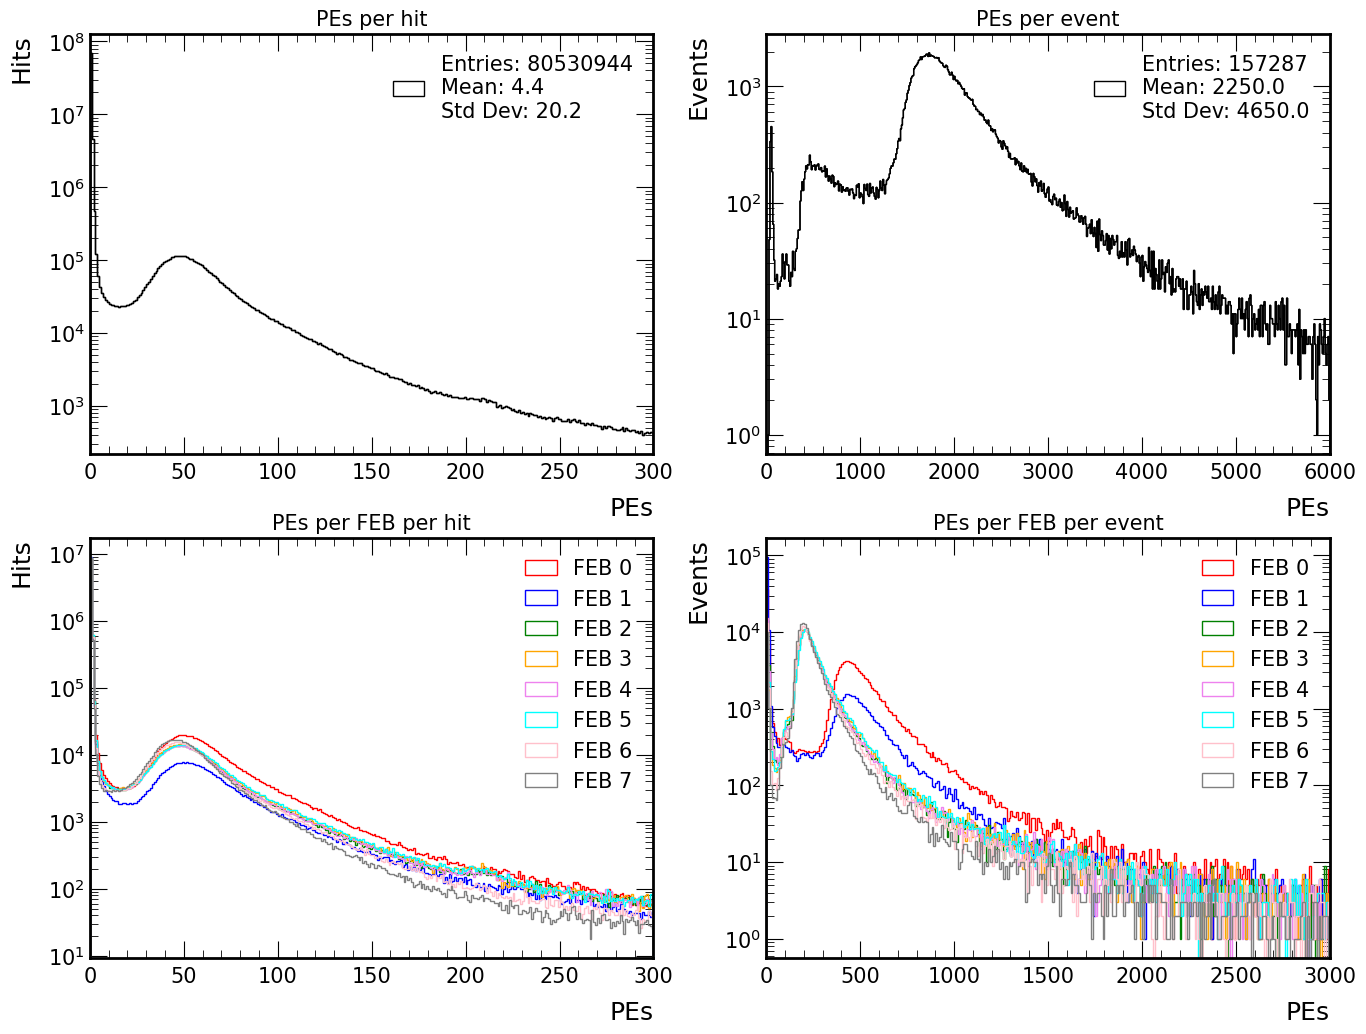

In [8]:
def pe_hists(arrays):
    # 4x4 plots
    fig, ax = plt.subplots(2, 2, figsize=(8*2, 6*2)) 
    
    pl.Plot1D(
        ak.flatten(arrays['PEsTemperatureCorrected'], axis=None),
        nbins=300, xmin=0, xmax=300,
        xlabel='PEs', ylabel='Hits', title='PEs per hit',
        log_y=True, ax=ax[0, 0] 
    )
    
    pes_per_event = ak.sum(arrays['PEsTemperatureCorrected'], axis=-1)
    pes_per_event = ak.sum(pes_per_event, axis=-1) # deal with nesting
    
    pl.Plot1D(
        ak.flatten(pes_per_event, axis=None), 
        nbins=600, xmin=0, xmax=6000,
        xlabel='PEs', ylabel='Events', title='PEs per event',
         log_y=True, ax=ax[0,1]
    )
    
    hists_ = {}
    for i_feb in range(8): 
        hists_[f'FEB {i_feb}'] = ak.flatten(arrays['PEsTemperatureCorrected'][:,i_feb,:], axis=None)
        
    pl.Plot1DOverlay(
        hists_,
        nbins=300, xmin=0, xmax=300,
        xlabel='PEs', ylabel='Hits', title='PEs per FEB per hit',
        log_y=True, ax=ax[1,0]
    )
    
    hists_ = {}
    for i_feb in range(8): 
        feb_pes_per_event = ak.sum(arrays['PEsTemperatureCorrected'][:,i_feb,:], axis=-1)
        hists_[f'FEB {i_feb}'] = ak.flatten(feb_pes_per_event, axis=None)
        
    pl.Plot1DOverlay(
        hists_,
        nbins=300, xmin=0, xmax=3000,
        xlabel='PEs', ylabel='Events', title='PEs per FEB per event',
        log_y=True, ax=ax[1,1]
    )

pe_hists(arrays)

## Channel mapping (get PEs/layer)

In [9]:
class CrvAging019: 
    """ Build PEs / layer for each module as 4x32 arrays per event """
    def __init__(self, arrays, sanity=True):
        """ Initialise """
        print("---> Loading CrvAging019...")
        self.arrays = arrays
        self.sanity = sanity # sanity checks
        self.n_layers = 4
        self.n_channels_per_layer = 32

    def check_layers(self, layers, reshape):
        """ Helper function to check reshaped data """ 
        # Compare with nested array layers
        for i_layer in range(self.n_layers):
            layer_match = np.array_equal(
                ak.to_numpy(layers[i_layer]),
                ak.to_numpy(reshape[:, i_layer, :])
            )
            if not layer_match:
                print(f"Layer {i_layer} mismatch!")
                print(f"Original layer {i_layer}:", ak.to_numpy(layers[i_layer])[0])
                print(f"Reshaped layer {i_layer}:", ak.to_numpy(T_reshape[:, i_layer ,:])[0])
            else:
                print(f"Layer {i_layer} matches ✓")
        
    def crv_L_end(self):
        """
        Map the L-end channels
        Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
        FEBs 6-7 are split into two layers (channels 0-31 and 32-63).
        Final shape: (events, 4 layers, 32 channels)
    
        Layer mapping:
        - Layer 0: FEB6, channels 0-31
        - Layer 1: FEB6, channels 32-63
        - Layer 2: FEB7, channels 0-31
        - Layer 3: FEB7, channels 32-63
        """
        
        # Configuration for L-end module
        feb_indices = [6, 7]  # FEB indices 
        
        # Reshape
        l_end_reshape = ak.to_numpy(
            self.arrays['PEsTemperatureCorrected'][:, min(feb_indices):(max(feb_indices)+1), :] #  [:, 6:8, 0:64] layers 0-3
        ).reshape(-1, self.n_layers, self.n_channels_per_layer) # -1, 4, 64
        
        # Store 
        self.arrays['PEs_per_layer_L_end'] = l_end_reshape
    
        # Check against layers mapped by hand 
        if self.sanity:

            layers = [
                self.arrays['PEsTemperatureCorrected'][:,6,0:32], 
                self.arrays['PEsTemperatureCorrected'][:,6,32:64],
                self.arrays['PEsTemperatureCorrected'][:,7,0:32], 
                self.arrays['PEsTemperatureCorrected'][:,7,32:64] 
            ]
            
            self.check_layers(layers, l_end_reshape)

        return self.arrays

    def crv_T(self, single_ended=True):
        """
        Map the T channels, handling both single and double-ended readout.
        Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
    
        For double-ended: sum of FEBs 2&4 and 3&5
        For single-ended: only FEBs 2&3
        
        Final shape: (events, 4 layers, 32 channels)
        
        Layer mapping:
        - Layer 0: FEB 2&4, channels 0-31
        - Layer 1: FEB 2&4, channels 32-63
        - Layer 2: FEB 3&5, channels 0-31
        - Layer 3: FEB 3&5, channels 32-63
        """
        print("\n---> Mapping CRV-T")
        
        # Initiliase numpy container for reshaped data
        T_reshape = [] 
        
        if single_ended:
        
            # Single-ended readout 
            feb_indices = [2, 3]  
            
            # Reshape
            T_reshape = ak.to_numpy(
                self.arrays['PEsTemperatureCorrected'][:, min(feb_indices):(max(feb_indices)+1), :] # [:, 2:6, 0:64]
            ).reshape(-1, self.n_layers, self.n_channels_per_layer)
        
        else: 
    
            # Double-ended readout
            feb_indices = [ (2,3), (4,5) ] 
    
            # Layers 0 & 1 
            T_01 = ak.to_numpy( 
                (self.arrays['PEsTemperatureCorrected'][:, feb_indices[0][0], :] + self.arrays['PEsTemperatureCorrected'][:, feb_indices[1][0], :]) # [:, 2, :] + [:, 4, :] layer 0 & 1
            ).reshape(-1, n_layers/2, n_channels_per_layer) # Shape: events:2:32
    
            # Layers 2 & 3 
            T_23 = ak.to_numpy( 
                (self.arrays['PEsTemperatureCorrected'][:, feb_indices[0][1], :] + self.arrays['PEsTemperatureCorrected'][:, feb_indices[1][1], :]) # [:, 3, :] + [:, 5, :] layer 2 & 3
            ).reshape(-1, n_layers/2, n_channels_per_layer) # Shape: events:2:32
    
            # Stack them along axis 1 to get final shape (events, 4, 32)
            T_reshape = np.concatenate([T_01, T_23], axis=1)

        # Store
        self.arrays['PEs_per_layer_T'] = T_reshape
 
        # Check against layers mapped by hand 
        if self.sanity:

            layers = [] 
            
            if single_ended:
                layers.append(self.arrays['PEsTemperatureCorrected'][:,2,0:32]) 
                layers.append(self.arrays['PEsTemperatureCorrected'][:,2,32:64])
                layers.append(self.arrays['PEsTemperatureCorrected'][:,3,0:32])
                layers.append(self.arrays['PEsTemperatureCorrected'][:,3,32:64]) 
            else: 
                layers.append((self.arrays['PEsTemperatureCorrected'][:,2,0:32] + self.arrays['PEsTemperatureCorrected'][:,4,0:32]))
                layers.append((self.arrays['PEsTemperatureCorrected'][:,2,32:64] + self.arrays['PEsTemperatureCorrected'][:,4,32:64]))
                layers.append((self.arrays['PEsTemperatureCorrected'][:,3,0:32] + self.arrays['PEsTemperatureCorrected'][:,5,0:32]))
                layers.append((self.arrays['PEsTemperatureCorrected'][:,3,32:64] + self.arrays['PEsTemperatureCorrected'][:,5,32:64]))

            self.check_layers(layers, T_reshape)

        return self.arrays

    def crv_DS(self):
        """
        Map the DS channels, this one is weird
        Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
        
        Final shape: (events, 4 layers, 32 channels)
        
        Layer mapping:
        - Layer 0: FEB 0&1, channels 0-15
        - Layer 1: FEB 0&1, channels 16-31
        - Layer 2: FEB 0&1, channels 32-48
        - Layer 3: FEB 0&1, channels 49-64
        """
        print("\n---> Mapping CRV-DS")
        
        # Reshape
        DS_reshape = ak.to_numpy( 
            ak.concatenate([
                self.arrays['PEsTemperatureCorrected'][:,1,0:16], self.arrays['PEsTemperatureCorrected'][:,0,15::-1], # Layer 0 
                self.arrays['PEsTemperatureCorrected'][:,1,16:32], self.arrays['PEsTemperatureCorrected'][:,0,31:15:-1], # Layer 1
                self.arrays['PEsTemperatureCorrected'][:,1,32:48], self.arrays['PEsTemperatureCorrected'][:,0,47:31:-1], # Layer 2
                self.arrays['PEsTemperatureCorrected'][:,1,48:64], self.arrays['PEsTemperatureCorrected'][:,0,63:47:-1] # # Layer 3
            ], axis=-1)
        ).reshape(-1, self.n_layers, self.n_channels_per_layer)

        # Store
        self.arrays['PEs_per_layer_DS'] = DS_reshape
    
        # Check against layers mapped by hand 
        if self.sanity:
            
            layers = [
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,0:16], self.arrays['PEsTemperatureCorrected'][:,0,15::-1]], axis=-1), 
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,16:32], self.arrays['PEsTemperatureCorrected'][:,0,31:15:-1]], axis=-1),
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,32:48], self.arrays['PEsTemperatureCorrected'][:,0,47:31:-1]], axis=-1),
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,48:64], self.arrays['PEsTemperatureCorrected'][:,0,63:47:-1]], axis=-1)
            ]
            self.check_layers(layers, DS_reshape)

        return self.arrays

In [10]:
# Run the mapping
# arrays = read_data()
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T()
arrays = crvaging019.crv_DS()
print()
arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

157287 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    time: 8 * 64 * float32,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0.916, 0, 0, 0, 0, 0, 1.12, 0, ..., 0, 1.13, 48.2, 64.3, 0, 0, 0, 0], ...]
time: [[1.12e+03, nan, nan, nan, nan, nan, ..., 863, 859, nan, nan, nan, nan], ...]
PEs_per_layer_L_end: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.07, ..., 0, 0, 0.886, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 

## Apply cuts

In [12]:
# Suppress zeros
def zero_mask(array):
    """
    Mask zeros in PEs/layer arrays
    
    Parameters:
    arrays: dictionary containing PE arrays
    array_name: name of array to mask ('PEs_per_layer_DS', 'PEs_per_layer_L_end', or 'PEs_per_layer_T')
    
    Returns:
    masked array with zeros removed
    """
    # Create mask (True for non-zero values)
    mask = array > 0

    # Apply mask
    return ak.mask(array, mask)

# Usage:
arrays['PEs_per_layer_DS'] = zero_mask(arrays['PEs_per_layer_DS'])
arrays['PEs_per_layer_L_end'] = zero_mask(arrays['PEs_per_layer_L_end'])
arrays['PEs_per_layer_T'] = zero_mask(arrays['PEs_per_layer_T'])

pr.PrintNEvents(arrays, 1)


---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0.916, 0, 0, 0, 0, 0, 1.12, 0, ..., 0, 1.13, 48.2, 64.3, 0, 0, 0, 0], ...]
time: [[1.12e+03, nan, nan, nan, nan, nan, ..., 863, 859, nan, nan, nan, nan], ...]
PEs_per_layer_DS: [[None, None, None, None, None, None, ..., None, None, None, None, 0.916], ...]
PEs_per_layer_L_end: [[None, None, None, None, None, None, ..., None, None, None, None, None], ...]
PEs_per_layer_T: [[None, None, None, None, None, None, ..., None, None, None, None, None], ...]
-------------------------------------------------------------------------------------



In [13]:
# Make fiducial cut on trigger modules 
# mask PEs / layer for L_end modules 

def fiducial_mask(arrays):
    """
    Create a mask for fiducial area cut, excluding outer 8 channels on each side.
    For 32 channels per layer: keep channels 8-23 (inclusive), mask 0-7 and 24-31
    """
    # Get the data shape from PEs_per_layer_L_end
    array = arrays['PEs_per_layer_L_end']
    
    # Create a boolean mask of the same shape as pe_data
    # True for channels we want to keep (8-23), False for channels we want to exclude
    mask = ak.Array([
        [
            [True if 8 <= i_channel < 24 else False for i_channel in range(32)]
            for i_layer in range(4)
        ]
        for ievent in range(len(array))
    ])
    
    # Mask
    return ak.mask(array, mask)

# Apply the mask
arrays['PEs_per_layer_L_end'] = fiducial_mask(arrays)

# pr_v.PrintNEvents(arrays, 1)
print(ak.to_list(arrays['PEs_per_layer_L_end'][0]))


[[None, None, None, None, None, None, None, None, None, 1.0654512643814087, None, None, None, None, None, None, None, None, None, None, 34.38727951049805, 42.91238784790039, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 46.770179748535156, 45.106815338134766, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1.509250521659851, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.9811116456985474, 1.2235779762268066, None, None, None, None, None, None, None, None, None, None, None, None, None, None]]


## Trigger

In [14]:
def get_triggers(arrays, thres=10):
    """
    Get triggers from nested PEs/layer arrays.
    Returns arrays with trigger flags
    """
    print("---> Triggering")
    
    # Sum channels for each layer
    layer_sums_L_end = ak.sum(arrays['PEs_per_layer_L_end'], axis=-1)  # [events, layer]
    layer_sums_DS = ak.sum(arrays['PEs_per_layer_DS'], axis=-1)        # [events, layer]
    
    # Create trigger flags for each layer
    arrays['trig_L_end_layers'] = ak.values_astype(layer_sums_L_end > thres, 'int')  # [events, layer]
    arrays['trig_DS_layers'] = ak.values_astype(layer_sums_DS > thres, 'int')        # [events, layer]
    
    # Check if all layers triggered
    arrays['trig_L_end'] = ak.values_astype(ak.sum(arrays['trig_L_end_layers'], axis=-1) == 4, 'bool')
    arrays['trig_DS'] = ak.values_astype(ak.sum(arrays['trig_DS_layers'], axis=-1) == 4, 'bool')
    
    # Combined trigger requirement
    arrays['trig'] = (arrays['trig_L_end'] & arrays['trig_DS'])

    n_tot = len(arrays)
    n_trig = len(arrays[arrays['trig']])
    trig_frac = n_trig/n_tot

    print(f"{n_trig}/{n_tot} = {100*trig_frac:.2f}% events have triggers")

# Apply triggers
get_triggers(arrays, thres=10)

# Exclude events with no trigger:
arrays = arrays[arrays['trig']]

---> Triggering
62579/157287 = 39.79% events have triggers


## Sort PEs in test module

In [15]:
# Histogram PEs per layer, sorted accorded to the lowest total PEs in each layer 
def sort_layer_PEs(array):
    """
    Sort PEs per layer within each event.
    Input: [events, layer, channel]
    Output: [events, layer] where layers are sorted by total PEs
    """
    # Sum channels for each layer 
    layer_sums = ak.sum(array, axis=-1)  # Shape: [events, layer]
    
    # Sort layer sums within each event
    sorted_layers = ak.sort(layer_sums, axis=-1)  # Shape: [events, layer] 
    
    return sorted_layers

# Sort 
# arrays['PEs_per_layer_L_end_fid_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end_fid'])
# arrays['PEs_per_layer_L_end_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end'])
arrays['PEs_per_layer_T_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_T'])
# arrays['PEs_per_layer_DS_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end'])
print("Sorted PEs:")
for i_event in range(10): 
    print(i_event, arrays['PEs_per_layer_T_sorted'][i_event])
print("...")

Sorted PEs:
0 [106, 116, 122, 153]
1 [100, 102, 109, 142]
2 [238, 252, 399, 438]
3 [82.9, 89.7, 98.2, 106]
4 [80.9, 103, 107, 278]
5 [95, 97.7, 117, 134]
6 [83.3, 83.8, 103, 108]
7 [82.8, 86, 97.7, 123]
8 [122, 127, 138, 161]
9 [49.9, 82.8, 95.7, 140]
...


In [ ]:
# # Get histograms
# fig, ax = plt.subplots(1, 4, figsize=(8*4, 6))

# hists = {}

# for i_sort in range(4):
#     array = ak.flatten(arrays['PEs_per_layer_T_sorted'][:,i_sort], axis=None) 
#     hists[f"Sort {i_sort}"] = ak.flatten(arrays['PEs_per_layer_T_sorted'][:,i_sort], axis=None) 
#     ylabel = "Events" 
#     if i_sort > 0: 
#         ylabel = "" 
        
#     pl.Plot1D(array,
#               # nbins=int(np.max(hists[i_sort]))/10, xmin=0, xmax=np.max(hists[i_sort]),
#               nbins=500, xmin=0, xmax=500,
#               xlabel="PEs / layer", ylabel=ylabel, title=f"Sorted PEs {i_sort}",
#               col="red", log_y=True, 
#               ax=ax[i_sort]
#              )

# pl.Plot1DOverlay(
#     hists, nbins=500, xmin=0, xmax=500,
#     xlabel="PEs / layer", ylabel="Events", title="Sorted PEs",
#     log_y=True, fout="../Images/EffAna/h1o_sorted_PEs.png"
# )

#     # Get histograms directly?
#     # ax[i_sort].hist(hists[i_sort], bins=1000, range=(0, 500), histtype='step', fill=False, density=False)

# # ax[0].hist(hists["a"], bins=1000, range=(0, 500), histtype='step', fill=False, density=False) 
# # ax[1].hist(hists["d"], bins=1000, range=(0, 500), histtype='step', fill=False, density=False) 
# # ax[2].hist(hists["c"], bins=1000, range=(0, 500), histtype='step', fill=False, density=False) 
# # ax[3].hist(hists["d"], bins=1000, range=(0, 500), histtype='step', fill=False, density=False) 

# # pl.Plot1DOverlay(
# #         hists_,
# #         nbins=300, xmin=0, xmax=300,
# #         xlabel='PEs', ylabel='Hits', title='PEs per FEB per hit',
# #         log_y=True, ax=ax[1,0]
# #     )

In [16]:
def init_hists(nbins=100, x_range=(0,500)): # Same range that Yuri uses
    """
    Initialise empty histograms for accumulation
    """
    hists = {}
    for i_sort in range(4):
        # Create empty histogram with metadata
        hists[i_sort] = {
            'counts': np.zeros(nbins),
            'bin_edges': np.linspace(x_range[0], x_range[1], nbins + 1),
            'n_fills': 0
        }
    return hists

def acc_hists(arrays, hists):
    """
    Accumulate histograms of sorted PEs/layer.
    Arrays: input data arrays.
    Histograms: existing histogram dictionary (if None, will be initialised)
    """
    # Initialise if not exists
    if hists is None:
        hists = init_hists()
    
    for i_sort in range(4):
        # Get flattened array for this sort index
        array = ak.to_numpy(
            ak.flatten(arrays['PEs_per_layer_T_sorted'][:,i_sort], axis=None)
        )
        
        # Create histogram data
        counts, _ = np.histogram(
            array, 
            bins=hists[i_sort]['bin_edges'],  # Use existing bin edges
        )

        # Accumulate counts
        hists[i_sort]['counts'] += counts
        hists[i_sort]['n_fills'] += 1
    
    return hists

hists = None 

# Fill from multiple files/threads
hists = acc_hists(arrays, hists)
# etc...

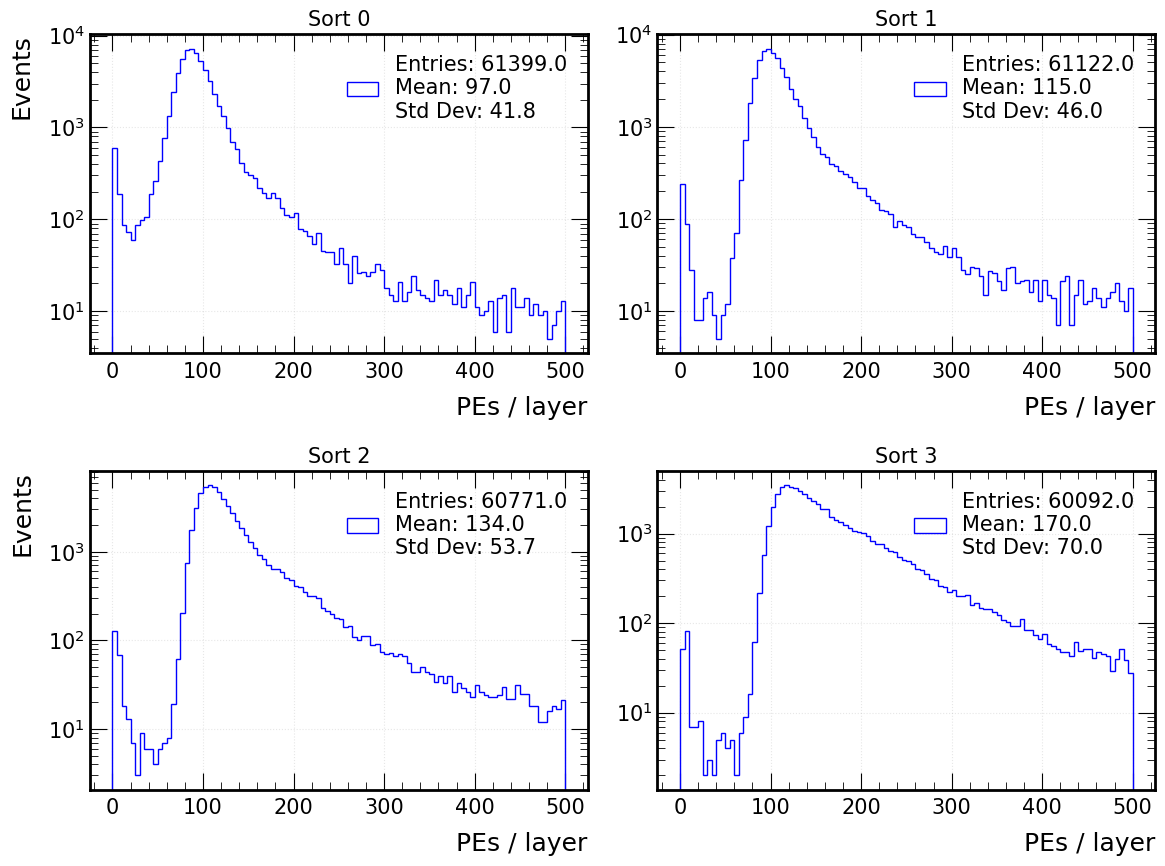

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(1.5*8, 1.5*6))
# fig.suptitle("Fill", fontsize=14, y=1.02)

for i_sort in range(len(hists)):
    
    # Convert i_sort to 2D index
    row = i_sort // 2
    col = i_sort % 2

    # Get histogram data
    counts = hists[i_sort]['counts']
    bin_edges = hists[i_sort]['bin_edges']
    bin_centres = (bin_edges[1:] + bin_edges[:-1])/2
    
    # Calculate stats
    n_entries = np.sum(counts)
    mean = np.sum(counts * bin_centres) / n_entries
    std_dev = np.sqrt(np.sum(counts * (bin_centres - mean)**2) / n_entries)
    
    # Plot histogram using bin edges and counts
    hist = ax[row,col].hist(
        x=hists[i_sort]['bin_edges'][:-1],  # Use left edges of bins
        bins=hists[i_sort]['bin_edges'],
        weights=hists[i_sort]['counts'],
        histtype='step',
        color='blue',
        log=True,
        label=f"Entries: {n_entries}\nMean: {pl.RoundToSigFig(mean, 3)}\nStd Dev: {pl.RoundToSigFig(std_dev, 3)}"
    )

    ax[row,col].set_title(f"Sort {i_sort}")
    ax[row,col].set_xlabel("PEs / layer")
    ax[row,col].set_ylabel("Events" if col == 0 else "")
    ax[row,col].grid(True, alpha=0.3)
    ax[row,col].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Scan inefficiency 

{'counts': array([2.410e+02, 8.800e+01, 2.800e+01, 8.000e+00, 8.000e+00, 1.400e+01,
       1.600e+01, 9.000e+00, 5.000e+00, 9.000e+00, 1.200e+01, 3.800e+01,
       7.100e+01, 2.640e+02, 7.260e+02, 1.796e+03, 3.425e+03, 5.263e+03,
       6.696e+03, 7.022e+03, 6.332e+03, 5.549e+03, 4.345e+03, 3.459e+03,
       2.559e+03, 2.014e+03, 1.671e+03, 1.243e+03, 9.790e+02, 7.820e+02,
       6.070e+02, 5.130e+02, 4.760e+02, 3.990e+02, 3.770e+02, 3.350e+02,
       3.070e+02, 2.860e+02, 2.490e+02, 2.140e+02, 2.140e+02, 1.760e+02,
       1.610e+02, 1.500e+02, 1.240e+02, 1.230e+02, 1.120e+02, 8.100e+01,
       9.600e+01, 8.600e+01, 8.100e+01, 6.800e+01, 6.300e+01, 6.400e+01,
       5.600e+01, 4.800e+01, 4.400e+01, 4.200e+01, 5.100e+01, 3.900e+01,
       4.800e+01, 3.900e+01, 2.800e+01, 2.500e+01, 3.000e+01, 2.900e+01,
       2.400e+01, 1.500e+01, 2.700e+01, 2.600e+01, 2.100e+01, 1.700e+01,
       2.900e+01, 3.000e+01, 2.000e+01, 2.100e+01, 2.200e+01, 1.600e+01,
       2.200e+01, 1.300e+01, 2.200e+01, 

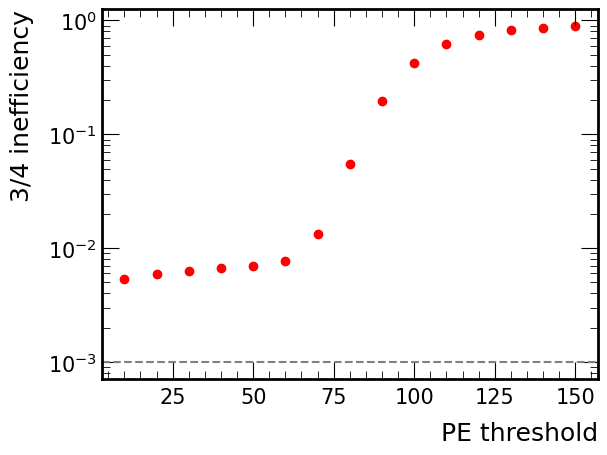

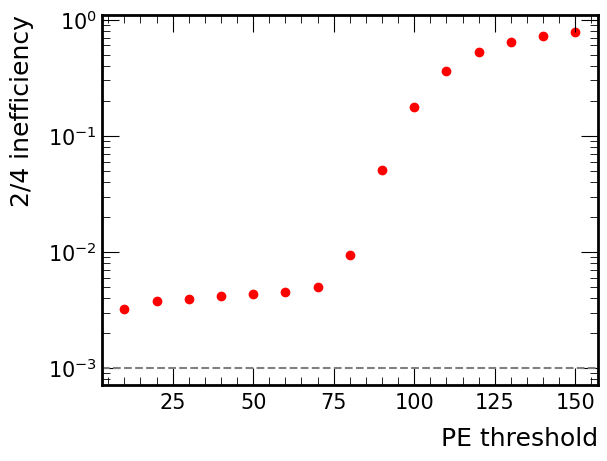

In [19]:
def scan_ineff(hist, start=10, end=150, steps=15):
    """
    Scan histogram to calculate inefficiency at different PE thresholds
    
    Parameters:
    hist: histogram dictionary with 'counts' and 'bin_edges'
    start: start value for scan
    end: end value for scan
    steps: number of points 
    threshold: initial PE threshold
    
    Returns:
    x: scan points
    y: inefficiency values (fraction of entries below threshold)
    """
    # Create scan points
    scan = np.linspace(start, end, steps)
    # Initialise x and y
    x = []
    y = []
    
    counts = hist['counts']
    bin_edges = hist['bin_edges']
    tot_counts = np.sum(counts)
    
    # For each scan point
    for thres in scan:
        # Find bins below threshold
        mask = bin_edges[:-1] < thres
        failures = np.sum(counts[mask])
        
        # Calculate inefficiency
        ineff = failures / tot_counts if tot_counts > 0 else 0
        
        x.append(thres)
        y.append(ineff)
    
    return np.array(x), np.array(y) 

print(hists[1])

fig, ax = plt.subplots() 
x, y = scan_ineff(hists[1])
ax.scatter(x, y)
ax.set_yscale("log")
ax.set_yscale("log")
ax.set_ylabel("3/4 inefficiency")
ax.set_xlabel("PE threshold")
ax.axhline(y=1e-3, color='gray', linestyle='--')
plt.show()

fig, ax = plt.subplots() 
x, y = scan_ineff(hists[2])
ax.scatter(x, y)
ax.set_yscale("log")
ax.set_yscale("log")
ax.set_ylabel("2/4 inefficiency")
ax.set_xlabel("PE threshold")
ax.axhline(y=1e-3, color='gray', linestyle='--')
plt.show()



    